# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

In [333]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1027


## Group Number : 33

## Student 1 
### Name : Martijn van Meerten
### ID : 4387902

## Student 2
### Name : Yannick Haveman
### ID : 4299078

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

## 1. Familiarization and discretization task – 1 A4

In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance
import warnings
warnings.filterwarnings("ignore")

In [305]:
df = pd.read_table('./dataset_10/capture20110818.binetflow', sep=",")
# Remove background data and clean up State feature
df = df[df['Label'].map(lambda x: 'Background' not in str(x))]
df.loc[df['State'].isna(),'State'] = 'NA'
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
532,2011/08/18 10:19:15.693956,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,3049,978731,245317,flow=From-Normal-V51-Grill
822,2011/08/18 10:19:18.143576,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
842,2011/08/18 10:19:18.303590,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
1021,2011/08/18 10:19:19.838272,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek
1022,2011/08/18 10:19:19.839123,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek


In [306]:
# Netflows from infected host '147.32.84.191'
df_inf = df[df['SrcAddr'].map(lambda x: '147.32.84.191' in str(x))]
df_inf.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
113304,2011/08/18 10:43:13.001890,0.000317,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V51-2-UDP-DNS
113476,2011/08/18 10:43:15.259378,0.010076,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V51-2-UDP-DNS
113477,2011/08/18 10:43:15.270377,0.038013,tcp,147.32.84.191,1027,->,74.125.232.201,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V51-2-TCP-HTTP-Google-Net-Est...
113608,2011/08/18 10:43:18.170284,0.010317,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,flow=From-Botnet-V51-2-UDP-DNS
113609,2011/08/18 10:43:18.182857,321.717560,udp,147.32.84.191,123,->,65.55.56.40,123,INT,0.0,NaN,4,360,360,flow=From-Botnet-V51-2-UDP-Attempt


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [307]:
# Separate normal data and botnet data
df_norm = df[df['Label'].map(lambda x: 'Normal' in str(x))]
df_all = df[df['Label'].map(lambda x: 'Botnet' in str(x))]
# Encode state
state_enc = LabelEncoder()
state_enc.fit(df['State'])
df['State'] = state_enc.transform(df.State)
df_norm['State'] = state_enc.transform(df_norm.State)
df_inf['State'] = state_enc.transform(df_inf.State)
df_all['State'] = state_enc.transform(df_all.State)

In [308]:
print(len(df_inf.loc[df_inf['TotBytes'] < 6000]) / len(df_inf))
print(len(df_norm.loc[df_norm['TotBytes'] < 6000]) / len(df_norm))

0.9537019322747273
0.9337414021581372


Most of the total bytes netflows are below 6000 bytes

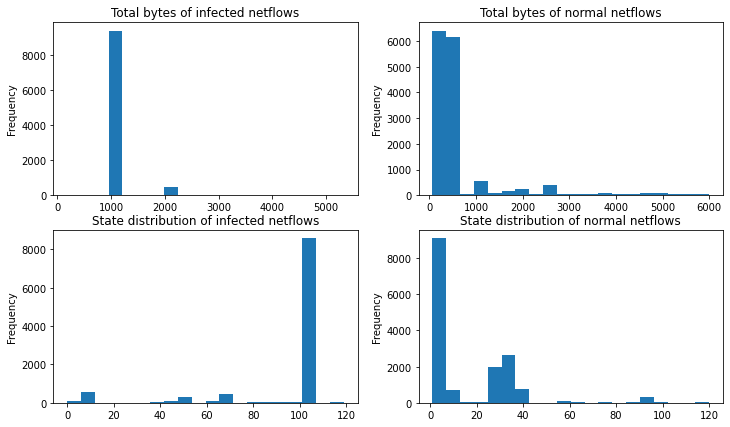

In [309]:
bins = 20
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(7)
df_inf.loc[df_inf['TotBytes'] < 6000]['TotBytes'].plot.hist(bins=bins, ax=ax[0][0], title='Total bytes of infected netflows');
df_norm.loc[df_norm['TotBytes'] < 6000]['TotBytes'].plot.hist(bins=bins, ax=ax[0][1], title='Total bytes of normal netflows');

df_inf['State'].plot.hist(bins=bins, ax=ax[1][0], title='State distribution of infected netflows');
df_norm['State'].plot.hist(bins=bins, ax=ax[1][1], title='State distribution of normal netflows');

In [334]:
bot_state = df_inf['State'].value_counts().idxmax()
print(state_enc.inverse_transform([bot_state]))
print(df_inf['State'].value_counts()[bot_state])

['FSPAC_FSRPA']
8507


The lower region of the total bytes data seems to show a good difference between normal and infected netflows. The state of the netflows shows a major difference, as almost only bots use the state 'FSPAC_FSPRA' and seems very promising for modelling bot-net behavior.

### 1b. Discretize selected features

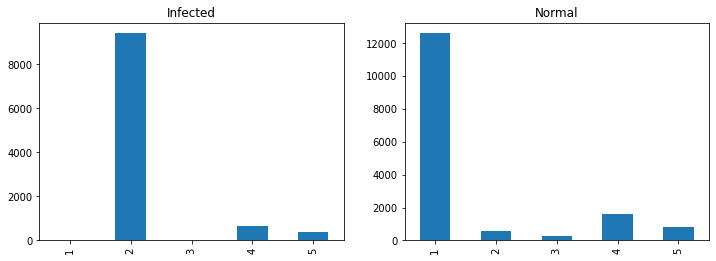

In [311]:
'''
Discretize total bytes with several bins, where [800, 1300] is most frequent for infected hosts
And [0, 800] is most frequent for normal hosts
'''
def discretize_tot_bytes(dataframe):    
    totBytesBins = [-1, 800, 1300, 1900, 10000, dataframe['TotBytes'].max()]
    totBytesLabels=[1,2,3,4,5]
    dataframe['TotBytes_disc'] = pd.cut(dataframe['TotBytes'], bins=totBytesBins, labels=totBytesLabels)

discretize_tot_bytes(df_inf)
discretize_tot_bytes(df_norm)
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
df_inf.TotBytes_disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[0], title="Infected");
df_norm.TotBytes_disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[1], title="Normal");

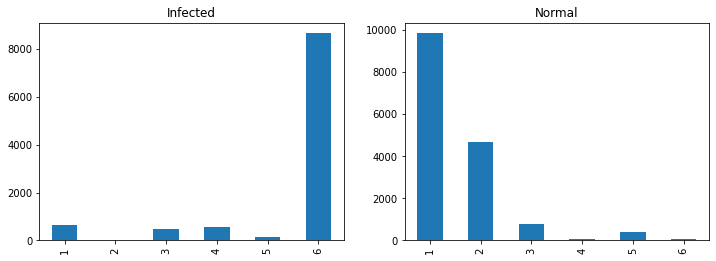

In [312]:
# Discretize encoded state in 6 roughly equally sized bins
def discretize_state(dataframe):
    totStateBins = [-1, 20, 40, 60, 80, 100, dataframe['State'].max() + 1]
    totStateLabels=[1,2,3,4,5,6]
    dataframe['State_disc'] = pd.cut(dataframe['State'], bins=totStateBins, labels=totStateLabels)

discretize_state(df_inf)
discretize_state(df_norm)
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
df_inf.State_disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[0], title="Infected");
df_norm.State_disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[1], title="Normal");

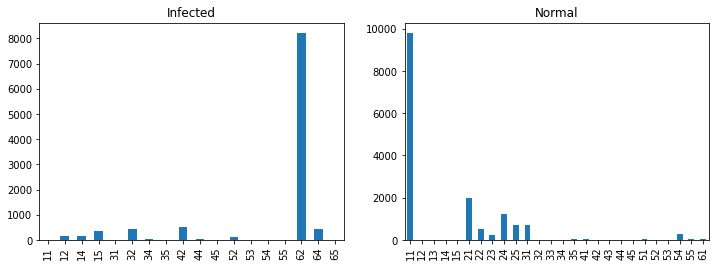

In [313]:
# Combine the two discretized values into one integer by appending
def combine_discrete_values(row, key1, key2):
    return int(str(int(row[key1])) + str(int(row[key2])))

# Apply combination to dataframe
def df_combine_discretization(dataframe):
    dataframe['disc'] = dataframe.apply (lambda row: combine_discrete_values(row, 'State_disc', 'TotBytes_disc'), axis=1)

df_combine_discretization(df_inf)
df_combine_discretization(df_norm)
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
df_inf.disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[0], title="Infected");
df_norm.disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[1], title="Normal");

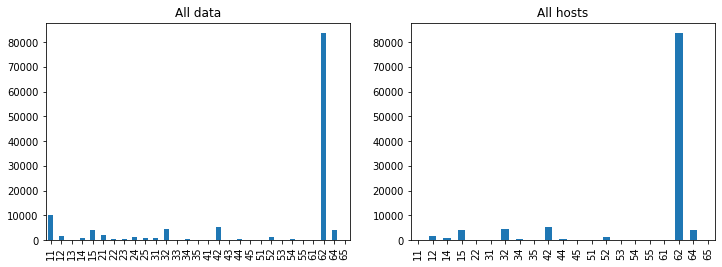

In [314]:
discretize_tot_bytes(df)
discretize_state(df)
df_combine_discretization(df)

discretize_tot_bytes(df_all)
discretize_state(df_all)
df_combine_discretization(df_all)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)

df.disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[0], title="All data");
df_all.disc.value_counts().sort_index().plot(kind = 'bar', ax=ax[1], title="All hosts");

### 1b. Answers and explanation

The combined discretized feature shows a clear discrepancy between infected netflows and normal netflows. This discrepancy also shows when combining all hosts. The value 62 seems to be a clear indicator for infected netflows as the absolute majority of the infected netflows have this value, while none of the normal netflows have this value. 62 is the result of state discretized value 6 and total bytes value 2. This also follows from the figures in 1a and the total bytes bin of \[800, 1300\].

## 6.Botnet profiling task – 1/2 A4

In [315]:
# Import all netflow datasets
df = []
df.append(pd.read_table('./dataset_9/capture20110817.binetflow', sep=","))
df.append(pd.read_table('./dataset_10/capture20110818.binetflow', sep=","))
df.append(pd.read_table('./dataset_11/capture20110818-2.binetflow', sep=","))
df.append(pd.read_table('./dataset_12/capture20110819.binetflow', sep=","))
df_tot = pd.concat(df, ignore_index=True)

# Encode state based on the combined dataset so we don't miss any states
state_enc = LabelEncoder()
df_tot.loc[df_tot['State'].isna(),'State'] = 'NA'
state_enc.fit(df_tot['State'])
for dataframe in df:
    dataframe.loc[dataframe['State'].isna(),'State'] = 'NA'
    dataframe['State'] = state_enc.transform(dataframe.State)
    # Discretize the total bytes and state for our combined 'disc' feature
    discretize_tot_bytes(dataframe)
    discretize_state(dataframe)
    df_combine_discretization(dataframe)

In [316]:
# Calculate unique 3-grams of the 'disc' feature
unique_disc = []
unique_ngram = []
for i in range(1,7):
    for j in range(1, 6):
        unique_disc.append(int(str(i) + str(j)))
        
for value1 in unique_disc:
    for value2 in unique_disc:
        for value3 in unique_disc:
            unique_ngram.append((value1, value2 ,value3))

### 6a. Learn a sequential model

In [317]:
'''
Create profiles per host based on the occurrence of 3-grams of 'disc' in the flows
'''
def create_ngram_profiles(df, window_size):
    profiles = {}
    # Group by src address
    host_flows = df.groupby(by=['SrcAddr'])
    # Get indices of rows per host
    hosts = host_flows.indices
    # Filter out hosts that have 10 or less flows
    hosts = {k: v for k, v in hosts.items() if len(v) > 10}
    disc = df['disc']
    for (host, indices) in hosts.items():
        # Determine 3-grams from each host
        three_grams = set(map(tuple, [disc.iloc[i:i+3] for i in indices[:-3]]))
        # Create boolean array, where each element is true if the 3-gram occurs and false if the 3-gram does not occur
        profiles[host] = [x in three_grams for x in unique_ngram]
        
    return profiles

# For each scenario get the profiles of all hosts
scenario_profiles = []
for dataframe in df:
    scenario_profiles.append(create_ngram_profiles(dataframe, 10))
    

In [318]:
# The chosen infected hosts for scenario 9-12 respecetively
inf_profiles = ['147.32.84.165', '147.32.84.191', '147.32.84.165', '147.32.84.165']
scenario_distances = []
for index, scenario in enumerate(scenario_profiles):
    distances = {}
    # For every host, determine the cosine distance of their profile to that of the infected profile
    for (host, profile) in scenario.items():
        dist = distance.cosine(scenario[inf_profiles[index]], profile)
        distances[host] = dist
        
    scenario_distances.append(distances)

In [319]:
print('Scenario 9:')
print(*list(sorted(scenario_distances[0].items(), key=lambda item: item[1]))[:20], sep='\n')
print('\nScenario 10:')
print(*list(sorted(scenario_distances[1].items(), key=lambda item: item[1]))[:20], sep='\n')
print('\nScenario 11:')
print(*list(sorted(scenario_distances[2].items(), key=lambda item: item[1]))[:10], sep='\n')
print('\nScenario 12:')
print(*list(sorted(scenario_distances[3].items(), key=lambda item: item[1]))[:10], sep='\n')

Scenario 9:
('147.32.84.165', 0.0)
('147.32.84.193', 0.2404794367867482)
('147.32.84.191', 0.24599999999999989)
('147.32.84.192', 0.24747119979252608)
('147.32.84.205', 0.2537579055149133)
('147.32.84.204', 0.2581163235166275)
('147.32.84.208', 0.25924362979451876)
('147.32.84.209', 0.26118115762165217)
('147.32.84.206', 0.26148582338179893)
('147.32.84.207', 0.2631118357127272)
('147.32.84.118', 0.36003862476103077)
('147.32.85.26', 0.3878475580013603)
('147.32.84.21', 0.4075959164663775)
('147.32.86.176', 0.41871256510465227)
('147.32.86.179', 0.4214075434563368)
('147.32.84.132', 0.42172574481814584)
('147.32.86.114', 0.4225281961770546)
('147.32.86.155', 0.4245556222500232)
('147.32.86.125', 0.4281239918700044)
('147.32.84.94', 0.43314033561921184)

Scenario 10:
('147.32.84.191', 0.0)
('147.32.84.165', 0.36046031231529285)
('147.32.84.193', 0.3634573360085752)
('147.32.84.207', 0.3706563706563706)
('147.32.84.206', 0.37810869200274266)
('147.32.84.209', 0.37836587756650364)
('147.3

### 6b. Analysis and answers to the questions.

We learn a 3-gram model on the individual hosts of all scenarios with more than ten flows in order to profile each host individually. The profile consists of a boolean array, indicating for each possible ngram, whether it exists in the host's flows. We compare the different profiles with cosine distance, resulting in the scores found above.

The results for each scenario show excellent performance for the detection of botnets. Scenario 9 has ten infected hosts that would all get detected by setting the threshold to 0.3. The same goes for scenario 10 with threshold 0.5. Scenario 12 contains three infected hosts which would get detected with threshold 0.45. scenario 11 has three infected hosts and with threshold 0.5 detects two. The last infected host is missing from the profiles due to filtering all hosts with 10 or fewer flows.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


In [320]:
import random
random.seed(42)

# Infected hosts for the different scenarios
infected_hosts_11_12 = ['147.32.84.191', '147.32.84.192']
infected_hosts_9_10 = ['147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
                  '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']

# Infected host used for fingerprinting
infected_host = ['147.32.84.165']

# Create training/testing data with one infected host in the training data and the others in the testing data
# split: The fraction of normal hosts in the test sets vs training sets
split = 0.3
training_data = [{}, {}, {}, {}]
testing_data = [{}, {}, {}, {}]

def train_test_split(profiles, infected_hosts, training_host, split):
    training_data = {}
    test_data = {}
    for (host, profile) in profiles.items():
        if host in infected_hosts:
            test_data[host] = profile
        elif host in training_host:
            training_data[host] = profile
        elif random.random() < split:
            test_data[host] = profile
        else:
            training_data[host] = profile
            
    return training_data, test_data

# Scenario 9 and 10
for index, scenario in enumerate(scenario_profiles[:2]):
    train_data, test_data = train_test_split(scenario, infected_hosts_9_10, infected_host, split)
    training_data[index] = train_data
    testing_data[index] = test_data
            
# Scenario 11 and 12
for index, scenario in enumerate(scenario_profiles[2:4]):
    train_data, test_data = train_test_split(scenario, infected_hosts_11_12, infected_host, split)
    training_data[index+2] = train_data
    testing_data[index+2] = test_data

infected_profiles = []
normal_profiles = []
xor_profiles = []

# Use the profiles for finding the fingerprint
# infected profile is the profile of host 147.32.84.165
# normal profile is the logical OR of all normal profiles in the set
for index, scenario in enumerate(training_data):
    infected_profile = np.array(training_data[index][infected_host[0]])
    normal_profile = np.array([False for _ in unique_ngram])
    for (host, profile) in scenario.items():
        if host not in infected_host:
            normal_profile = normal_profile | np.array(profile)
            
    infected_profiles.append(infected_profile)
    normal_profiles.append(normal_profile)
    xor_profiles.append(np.logical_xor(infected_profile, normal_profile))

In [321]:
fingerprints = []
for i in range(4):
    # Find the ngrams that are not present in normal flows, but present in infected flows
    fingerprint = np.argwhere(xor_profiles[i] & infected_profiles[i])
    fingerprint = np.array(unique_ngram, dtype='i,i,i')[fingerprint.flatten()]
    fingerprints.append(fingerprint)
    
scores_scenario = []
for index, test_data in enumerate(testing_data):
    scores = {}
    for (host, profile) in test_data.items():
        ngrams_in_profile = np.array(unique_ngram, dtype='i,i,i')[np.array(profile)]
        # Intersection of the ngram lists gives the ngrams that are in the fingerprint and in the inspected host
        intersection = np.intersect1d(ngrams_in_profile, fingerprints[index])
        # Score based on the fraction of ngrams in the intersection and in the fingerprint
        scores[host] = len(intersection) / len(fingerprints[index])
    
    scores_scenario.append(scores)

In [322]:
print('Scenario 9:')
print(*list(sorted(scores_scenario[0].items(), key=lambda item: item[1], reverse=True))[:20], sep='\n')
print('\nScenario 10:')
print(*list(sorted(scores_scenario[1].items(), key=lambda item: item[1], reverse=True))[:20], sep='\n')
print('\nScenario 11:')
print(*list(sorted(scores_scenario[2].items(), key=lambda item: item[1], reverse=True))[:10], sep='\n')
print('\nScenario 12:')
print(*list(sorted(scores_scenario[3].items(), key=lambda item: item[1], reverse=True))[:10], sep='\n')

Scenario 9:
('147.32.84.193', 0.125)
('147.32.84.94', 0.125)
('147.32.84.191', 0.0625)
('147.32.84.209', 0.0625)
('147.32.85.26', 0.0625)
('147.32.86.165', 0.0625)
('65.49.11.19', 0.0625)
('10.10.20.233', 0.0)
('10.8.0.98', 0.0)
('101.108.25.210', 0.0)
('109.117.10.107', 0.0)
('109.164.137.4', 0.0)
('109.171.128.9', 0.0)
('109.172.66.33', 0.0)
('109.173.36.109', 0.0)
('109.184.159.239', 0.0)
('109.201.232.126', 0.0)
('109.205.60.70', 0.0)
('109.231.234.212', 0.0)
('109.236.80.143', 0.0)

Scenario 10:
('147.32.84.207', 0.5949367088607594)
('147.32.84.191', 0.5822784810126582)
('147.32.84.192', 0.5822784810126582)
('147.32.84.205', 0.5443037974683544)
('147.32.84.193', 0.5316455696202531)
('147.32.84.208', 0.5316455696202531)
('147.32.84.209', 0.5063291139240507)
('147.32.84.204', 0.4810126582278481)
('147.32.84.206', 0.4430379746835443)
('147.32.96.69', 0.4050632911392405)
('147.32.84.229', 0.05063291139240506)
('89.235.37.130', 0.05063291139240506)
('147.32.84.118', 0.0379746835443038)

In [323]:
def evaluate(scenario, scores, threshold, inf_hosts):
    positives = dict(filter(lambda elem: elem[1] > threshold, scores.items()))
    true_positives = len(np.intersect1d(np.array(list(positives.keys())), np.array(inf_hosts)))
    false_positives = len(positives) - true_positives
    false_negatives = len(inf_hosts) - true_positives
    true_negatives = len(scores) - len(positives) - false_negatives
    print(f'{scenario}: TP: {true_positives}, TN: {true_negatives}, FP: {false_positives}, FN: {false_negatives}')
    
evaluate('Scenario 9 ', scores_scenario[0], 0.1, infected_hosts_9_10)
print(f'fingerprint length: {len(fingerprints[0])}')
evaluate('Scenario 10', scores_scenario[1], 0.1, infected_hosts_9_10)
print(f'fingerprint length: {len(fingerprints[1])}')
evaluate('Scenario 11', scores_scenario[2], 0.1, infected_hosts_11_12)
print(f'fingerprint length: {len(fingerprints[2])}')
evaluate('Scenario 12', scores_scenario[3], 0.1, infected_hosts_11_12)
print(f'fingerprint length: {len(fingerprints[3])}')

Scenario 9 : TP: 1, TN: 828, FP: 1, FN: 8
fingerprint length: 16
Scenario 10: TP: 9, TN: 591, FP: 1, FN: 0
fingerprint length: 79
Scenario 11: TP: 1, TN: 52, FP: 0, FN: 1
fingerprint length: 50
Scenario 12: TP: 0, TN: 122, FP: 0, FN: 2
fingerprint length: 4


### 7b. Analysis and answers to the questions.

For scenario 10 and 11, fingerprinting gives good results. Scenario 10 has 9 TP, 1 FP and 0 FN. Scenario 11 has 1 TP, 0 FP and 1 FN, again due to one infected host missing from the data. For scenarios 9 and 12, fingerprinting performs poorly. Scenario 9 has 1 TP, 1 FP and 8 FN. Scenario 12 has 0 TP, 0 FP and 2 FN. This can be attributed to the number of ngrams in the fingerprint. Scenario 9 has 16 ngrams and scenario 12 has 4, while scenario 10 has 79 ngrams and scenario 11 has 50. For scenario 12 this results in none of the ngrams appearing in any of the other flows. It is also important to note that in this evaluation a score is calculated on the suspiciousness of hosts by taking the fraction of ngrams in the fingerprint that occurr in the host. The threshold is set to 0.1 to increase performance. In a real-time situation, hosts are classified as infected as soon as one, or multiple of the fingerprint ngrams are detected. This can be tweaked to the desired sensitivity.

Fingerprinting performs worse than profiling. Profiling achieves 100% accuracy on the dataset. Although the methods do not differ substantially, the main benefit of profiling is that it also takes into account the absence/presence of normal flow ngrams in its classification. Fingerprinting has the advantage that it can be used in real-time, allowing a network operator to act quickly on any host showing infected behavior. Profiling requires a large number of netflows to construct a profile and classify a host, thereby decreasing reaction speed.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.

In [324]:
df_10 = pd.read_table('./dataset_10/capture20110818.binetflow', sep=",")
# Class label 
df_10.loc[df_10['Label'].str.contains('Botnet'), 'Labell'] = 1 # infected
df_10.loc[df_10['Label'].str.contains('Normal'), 'Labell'] = 0
df_10.loc[df_10['Label'].str.contains('Background'), 'Labell'] = 0
df_10 = df_10.drop(columns=['Label', 'StartTime'])

# clean up data
df_10.loc[df_10['State'].isna(),'State'] = 'NA'
df_10.loc[df_10['Dport'].isna(),'Dport'] = 0
df_10.loc[df_10['Sport'].isna(),'Sport'] = 0
df_10.loc[df_10['sTos'].isna(),'sTos'] = 0
df_10.loc[df_10['dTos'].isna(),'dTos'] = 0

df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))

# One hot encoding
one_hot_encode_cols = [
    'Proto',
    'State',
    'Dir'
]

df_10 = pd.get_dummies(df_10, columns=one_hot_encode_cols)

addr_encoder = LabelEncoder()
addr_encoder.fit(df_10['SrcAddr'].append(df_10['DstAddr']))
df_10['SrcAddr'] = addr_encoder.transform(df_10.SrcAddr)
df_10['DstAddr'] = addr_encoder.transform(df_10.DstAddr)

# Get target
y = df_10["Labell"].to_numpy().astype(int)
df_10.drop(columns=["Labell"], inplace=True)

X = df_10.to_numpy().astype(float)

In [325]:
print(len(y))
print(y.sum())

1309791
106352


There is a class imbalance, but we use naive bayes so we don't SMOTE.

In [326]:
### This cell takes over 15 minutes ###

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

n_folds = 5
k = 8
k_fold = StratifiedKFold(n_splits=n_folds)
y_white_predictions = np.zeros(len(y))
y_white_index_arrays = []
for train_index, test_index in k_fold.split(X, y):
    print("New fold")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    y_white_predictions[test_index] = y_pred_proba
    y_white_index_arrays.append(test_index)

New fold
New fold
New fold
New fold
New fold


In [327]:
def tp_fp(y_prediction_probabilities, y, threshold):
    y_pred = np.where(y_prediction_probabilities > threshold, 1, 0)
    true_positive_count = sum(a == 1 and b == 1 for a, b in zip(y_pred, y))
    false_positive_count = sum(a == 1 and b == 0 for a, b in zip(y_pred, y))
    print("True positives: " + str(true_positive_count))
    print("False positives: " + str(false_positive_count))
    TPR = true_positive_count / y.sum()
    FPR = false_positive_count / (len(y) - y.sum())
    print(f'TPR: {TPR}, FPR: {FPR}')

    
tp_fp(y_white_predictions, y, 0.99999999)

True positives: 21143
False positives: 83175
TPR: 0.1988020911689484, FPR: 0.06911442956394134


#### Precision, recall, fscore

In [328]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def precision_recall_fscore(y, y_pred, average):
    precision = precision_score(y, y_pred, average=average)
    recall = recall_score(y, y_pred, average=average)
    fscore = f1_score(y, y_pred, average=average)
    return (precision, recall, fscore)

precision, recall, fscore = precision_recall_fscore(y, np.where(y_white_predictions > 0.99999999, 1, 0), 'binary')
print(f'Precision: {precision}, recall: {recall}, fscore: {fscore}')

Precision: 0.20267834889472575, recall: 0.1988020911689484, fscore: 0.20072150757108273


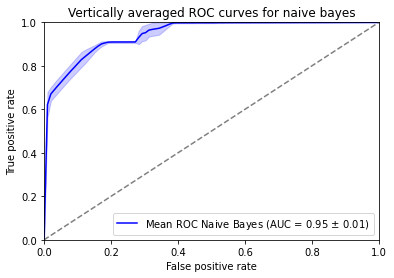

In [329]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
    
# Plot the mean roc curve
def plot_mean_roc(y_predictions, y_index_arrays):
    n_folds = 5
    color = 'blue'
    classifier_name = 'Naive Bayes'

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for test_index in y_index_arrays:
        y_pred = y_predictions[test_index]
        y_test = y[test_index]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (classifier_name, mean_auc, std_auc), color=color)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)

    plt.legend(loc="lower right")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Vertically averaged ROC curves for naive bayes")
    plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

plot_mean_roc(y_white_predictions, y_white_index_arrays)

In [330]:
threshold = 0.99999999
y_pred = np.where(y_white_predictions > threshold, 1, 0)
df_10 = pd.read_table('./dataset_10/capture20110818.binetflow', sep=",")
df_10['prediction'] = y_pred

In [331]:
# Group by src address
host_flows = df_10.groupby(by=['SrcAddr'])
# Get indices of rows per host
hosts = host_flows.indices

# Determine classification score for each host
host_detection_score = {}
for host, indices in hosts.items():
    # Score is fraction of infected classified flows over total number of flows
    host_detection_score[host] = df_10['prediction'][indices].sum() / len(df_10['prediction'][indices])

In [332]:
threshold = 0.15

inf_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
                  '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']

evaluate('Scenario 10 ', host_detection_score, threshold, inf_hosts)

Scenario 10 : TP: 10, TN: 151201, FP: 45, FN: 0


The scores for classifying individual netflows are quite poor. The naive bayes classifier with threshold 0.99999999 has a TPR of 0.199 and FPR of 0.069, with 83175 FP and therefore 83175 false alarms. Transforming the classifier to a host classifier however seems to have better results. Hosts are scored on the fraction of infected classified flows over the total number of flows. This results in 10 TP, 45 FP and 0 FN. 

We prefer using a sequential model for detecting botnets. A classifier does not take into account sequential netflows. Much of the behavior of botnets is captured in the sequence of one host's netflows. The performance of this classifier is best compared to the fingerprinting model, as a classifier is also able to classify netflows in real-time. The performance of the fingerprinting model on scenario 10 is better in this analysis. It would be interesting to compare the classifier to fingerprinting on scenarios 9 and 12, where fingerprinting showed poor results, but due this is not done due to time constraints.

In [337]:
!pip freeze

altgraph==0.17
anyio==2.2.0
appdirs==1.4.4
appnope==0.1.2
argon2-cffi==20.1.0
asgiref==3.3.1
async-generator==1.10
attrs==20.3.0
Babel==2.9.0
backcall==0.2.0
bleach==3.3.0
cachetools==4.2.0
certifi==2020.12.5
cffi==1.14.5
chardet==4.0.0
colorama==0.4.4
cycler==0.10.0
Cython==0.29.23
decorator==5.0.7
defusedxml==0.7.1
deprecation==2.1.0
distro==1.5.0
Django==3.1.6
django-braces==1.14.0
django-crontab==0.7.1
django-highcharts==0.1.7
entrypoints==0.3
future==0.18.2
gunicorn==20.1.0
idna==2.10
imbalanced-learn==0.8.0
imblearn==0.0
install==1.3.4
ipykernel==5.5.3
ipython==7.22.0
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==2.11.3
joblib==1.0.1
json5==0.9.5
jsonschema==3.2.0
jupyter-client==6.1.12
jupyter-core==4.7.1
jupyter-packaging==0.9.2
jupyter-server==1.6.4
jupyterlab==3.0.14
jupyterlab-pygments==0.1.2
jupyterlab-server==2.4.0
kiwisolver==1.3.1
llvmlite==0.36.0
lxml==4.6.2
MarkupSafe==1.1.1
matplotlib==3.4.1
mistune==0.8.4
mysqlclient==2.0.3
nbclassic==0.2.7
nbclient==0.5.3
nbconvert==